### Q2a)

In [27]:
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt
import scipy.stats as sp

In [21]:
# Auxiliary functions

def generate_samples(n, m, negative_class):
    """
    Generate a sample vector of shape m x n
    Inputs:
    m, n : number of samples and length of dimension
    negative_class: label for negative class (either 0 or -1)
    
    Output:
    matrix of size m x n
    """
    choices = [1, negative_class]
    
    return np.random.choice(choices, size = (m, n))

def compute_av_gen_err_exact(model, n, m, isOnline = False, is1NN = False, isWinnow = False):
    """
    Computes average generalisation error exactly. 
    But can only be done for relatively small m and n. Too large and the computation becomes
    too expensive
    
    isOnline = if winnow or perceptron, then must specify # epochs to train on
    is1NN = if 1NN, no training. Directly predict
    """
    # Generate all possible length n samples
    
    if isWinnow:
        all_samples = np.array([list(i) for i in itertools.product([0,1],repeat= n)])
        all_labels = all_samples[:, 0]
    else:
        all_samples = np.array([list(i) for i in itertools.product([-1,1],repeat= n)])
        all_labels = all_samples[:, 0]
    
    # Generate all possible size m training samples, train the model on these, and then predict on all_samples
    gen_err_sum = 0; train_set_count = 0
    for choice in itertools.product(range(all_samples.shape[0]), repeat = m):
        choice = np.array(choice)
        train_samples = all_samples[choice, :]; train_labels = train_samples[:, 0]
        if is1NN:
            # Simply use model's test function would suffice, since we expect n and m to be relatively small anyway
            _, all_preds = model.test(train_samples, train_labels, all_samples)
            # Evaluate
            gen_error = np.mean(all_preds != all_labels)
        else:
            if isOnline:
                _, ph = model.train(train_samples, train_labels, 1, early_stopping = True)
                gen_error, all_preds = model.test(all_samples, all_labels)
            else:
                _, ph = model.train(train_samples, train_labels)
                gen_error, all_preds = model.test(all_samples, all_labels)
        
        gen_err_sum += gen_error; train_set_count += 1
        
                
    return gen_err_sum / train_set_count

def compute_av_gen_err_almost_exact(model, n, m, n_trainsets, isOnline = False, is1NN = False, isWinnow = False):
    """
    Computes average generalisation error almost exactly, i.e. evaluate on all possible test samples, so generalisation error
    is exact. But the average of this is not, because we sample a subset of all possible training samples of size m.
    
    But can only be done for relatively small n. Too large and the computation becomes
    too expensive
    
    isOnline = if winnow or perceptron, then must specify # epochs to train on
    is1NN = if 1NN, no training. Directly predict
    """
    # Generate all possible length n samples
    if isWinnow:
        all_samples = np.array([list(i) for i in itertools.product([0,1],repeat= n)])
        all_labels = all_samples[:, 0]
    else:
        all_samples = np.array([list(i) for i in itertools.product([-1,1],repeat= n)])
        all_labels = all_samples[:, 0]
    
    # Generate subsets of m training samples, train the model on these, and then predict on all_samples
    gen_err_sum = 0; train_set_count = 0
    for set_count in range(n_trainsets):
        choice = np.random.choice(np.arange(all_samples.shape[0]), size = (m))
        train_samples = all_samples[choice, :]; train_labels = train_samples[:, 0]
        if is1NN:
            # Simply use model's test function would suffice, since we expect n and m to be relatively small anyway
            _, all_preds = model.test(train_samples, train_labels, all_samples)
            # Evaluate
            gen_error = np.mean(all_preds != all_labels)
        else:
            if isOnline:
                _, ph = model.train(train_samples, train_labels, 1, early_stopping = True)
                gen_error, all_preds = model.test(all_samples, all_labels)
            else:
                _, ph = model.train(train_samples, train_labels)
                gen_error, all_preds = model.test(all_samples, all_labels)
        
        gen_err_sum += gen_error; train_set_count += 1
        
                
    return gen_err_sum / train_set_count

def compute_av_gen_err_approx(model, n, m, n_trainsets, n_testpts, isOnline = False, is1NN = False, isWinnow = False, seed = None):
    """
    Computes average generalisation error approximately, by replacing all expectations to empirical means
    
    
    isOnline = if winnow or perceptron, then must specify # epochs to train on
    is1NN = if 1NN, no training. Directly predict
    isWinnow = if winnow, negative class is 0
    """
    n_epochs = 1
    neg_class = 0 if isWinnow else -1
    # Generate subsets of size m training samples
    gen_err_sum = 0; train_set_count = 0
    for set_count in range(n_trainsets):
        # Generate subset of test samples, from all possible test samples. Only for non 1NN since we expect 1NN would take 
        # large training samples and we must use the on-the-fly method
        if not is1NN:
            train_samples = generate_samples(n, m, neg_class); train_labels = train_samples[:, 0]
            test_samples = generate_samples(n, n_testpts, neg_class); test_labels = test_samples[:,0]
            if isOnline:
                _, ph = model.train(train_samples, train_labels, n_epochs, early_stopping = True)
                gen_error, all_preds = model.test(test_samples, test_labels)
            else:
                _, ph = model.train(train_samples, train_labels)
                gen_error, all_preds = model.test(test_samples, test_labels)
                
        else: # for 1NN, use on-the-fly method
            gen_error = test_1nn(model, m, n_testpts, n, seed_glob = set_count + seed, bs_train = 10000, bs_test = 1000)
        
        
        gen_err_sum += gen_error; train_set_count += 1

                
    return gen_err_sum / train_set_count 

In [227]:
# Implementing the algorithms

class Perceptron():
    
    def __init__(self):
        # weights are 1 x n. But we initialize at train so we don't need to recreate every time
        self.weights = 0
        
    def train(self, train_data, train_labels, n_epochs, early_stopping = False):
        """
        train_data : m x n where m = # samples
        train_labels : vector of length m
        """
        # Initialize here so we don't need to re-create class instance
        m, data_dim = train_data.shape
        self.weights = np.zeros((1, data_dim))
        mistakes = 0
        total_mistakes = 0
        
        # For automatic stopping
        duration = 3 # if accuracy doesn't increase significantly over 3 epochs, we stop
        elapsed = 0; threshold = 0.00001 if (0.00001 < 1/m) else 1/m # for small samples, 1 sample matters more than big sample sizes
        old_acc = -1
        
        for epoch in range(n_epochs):
            mistakes = 0
#             print(f"Processing epoch {epoch}")
            for i in range(m):
                label = train_labels[i]
                # By convention, 0 always a mistake
                pred = train_data[i].reshape(1,-1) @ self.weights.T
                
                if pred * label <= 0:
                    self.weights += train_data[i] * label
                    mistakes += 1
                    
            total_mistakes += mistakes
            curr_acc = mistakes / m
#             print(f"At epoch {epoch}, error_rate is {curr_acc}")
            
            diff = curr_acc - old_acc
            if diff <= threshold:
                elapsed += 1
            else:
                elapsed = 0
            old_acc = curr_acc
            
            if elapsed >= duration:
#                 print(f"Early convergence at epoch {epoch}")
                break
#                 if early_stopping:
#                     break
            
        preds_train = 2*((train_data @ self.weights.T) >= 0) - 1
            
        return total_mistakes, preds_train.reshape(-1)
    
    def test(self, test_data, test_labels):
        """
        Inputs: same shape convention as train
        """
        preds = test_data @ self.weights.T
        test_preds = 2*(preds >= 0) - 1
        # Force predictions where argument is 0, to be a mistake
        test_preds = (test_preds + 8 * (preds == 0)).reshape(-1)
        
        
        error_rate = np.mean(test_preds != test_labels)
        
        return error_rate, test_preds
    

class Winnow():
    
    def __init__(self):
        # Again, initialize at train
        self.weights = 0
        
        
    def train(self, train_data, train_labels, n_epochs, early_stopping = False):
        """
        same shape convention as earlier. Note: for winnow, data is element of {0,1}, and so is label
        """
        
        # Initialize
        total_mistakes = 0
        m, n = train_data.shape
        self.weights = np.ones((1, n))
        
        # For automatic stopping
        duration = 3 # if accuracy doesn't increase significantly over 3 epochs, we stop
        elapsed = 0; threshold = 0.00001 if (0.00001 < 1/m) else 1/m # for small samples, 1 sample matters more than big sample sizes
        old_acc = -1
        
        for epoch in range(n_epochs):
            mistakes = 0
            
            for i in range(m):
                sample = train_data[i].reshape(1,-1)
                label = train_labels[i]
                
                preds = 1* ((sample @ self.weights.T) >= n)
                
                if label != preds:
                    mistakes += 1
                    self.weights *= 2 ** ((label - preds) * sample.astype(np.float32))
                    
            total_mistakes += mistakes
            curr_acc = mistakes / m
#             print(f"At epoch {epoch}, error_rate is {curr_acc}")
            
            diff = curr_acc - old_acc
            if diff <= threshold:
                elapsed += 1
            else:
                elapsed = 0
            old_acc = curr_acc
            
            if elapsed >= duration:
#                 print(f"Early convergence at epoch {epoch}")
                break
            
        
        preds_train = 1*((train_data @ self.weights.T) >= n)
        
        return total_mistakes, preds_train.reshape(-1)
    
    def test(self, test_data, test_labels):
        """
        Inputs: same shape convention as train
        """
        n = test_data.shape[1]
        preds = test_data @ self.weights.T
        test_preds = (1*(preds >= n)).reshape(-1)
        
        
        error_rate = np.mean(test_preds != test_labels)
        
        return error_rate, test_preds
    
    
class LinearRegression():
    
    def __init__(self):
        self.weights = 0
        
    def train(self, train_samples, train_labels):
        """
        Input: same convention as earlier
        """
        # Initialization
        m, n = train_samples.shape
        
        # Since batch algo, solution is obtained instantly
        self.weights = np.linalg.lstsq(train_samples, train_labels, rcond = None)[0] # rcond = None to surpress warnings
        
        # Alternative (from project document)
        # self.weights = np.linalg.pinv(train_samples)
        
        # Evaluate on training samples to compute 'mistakes'
        pred_arg = (train_samples @ self.weights.reshape(-1,1)).reshape(-1)
        train_pred = np.sign(pred_arg)
        
        # Penalize for predicting zeroes
        train_pred += 8 * (pred_arg == 0)
        
        # Count mistakes
        mistake_rate = np.mean(train_pred != train_labels)
        
        return mistake_rate, train_pred
    
    def test(self, test_samples, test_labels):
        """
        Input: same convention as earlier
        """
        pred_arg = (test_samples @ self.weights.reshape(-1,1)).reshape(-1)
        test_pred = np.sign(pred_arg)
        test_pred += 8 * (pred_arg == 0)
        mistake_rate = np.mean(test_pred != test_labels)
        
        return mistake_rate, test_pred
    
class one_nn():
    
    def __init__(self):
        
        self.train_samples = 0
        self.train_labels = 0
        
    
    def test(self, train_samples, train_labels, test_samples):
        """
        Input:
        train_samples, test_samples, train_labels = same convention as previous
        Note: the train samples and test samples passed here is just a batch of all the train_samples. So is the test. Hence
        this function computes the shortest distance and corresponding label for the fed in test samples, towards the fed in
        training samples, assuming both sizes are reasonable
        
        There is no training for 1-nn, since it is just storing all the training samples and labels
        Note if training samples get too large, just feed in batches of training samples, and find the nearest
        point by running test. Then record the label and the closest distance, and feed in the next batch and update
        the label if new nearest is found. Do until all training samples are exhausted
        
        Since this test function 'predicts' using batches of training samples, the test accuracy is evaluated outside
        
        """
        
        m, n = test_samples.shape
        
        Sx = np.sum(train_samples * train_samples, axis = 1).reshape(-1,1)
        Sy = np.sum(test_samples * test_samples, axis = 1).reshape(1,-1)
        Sxy = train_samples @ test_samples.T
        
        distances_train_test = Sx + Sy - 2 * Sxy # so distances[i,j] = squared dist between ith train and jth test point
        
        near_idx = np.argmin(distances_train_test, axis = 0)
        
        near_distances = distances_train_test[near_idx, np.arange(m)]
        test_labels = train_labels[near_idx]
        
        return near_distances, test_labels
    
def test_1nn_beta(model, m_train, m_test, n, seed_glob = 88, bs_train = 10000, bs_test = 1000):
    """
    Function to evaluate 1nn by generating training and test points on the fly. 
    """
    num_batch_train = m_train // bs_train if m_train % bs_train == 0 else m_train // bs_train + 1
    num_batch_test = m_test // bs_test if m_test % bs_test == 0 else m_test // bs_test + 1
    
    # For testing purposes only
    test_cat = np.zeros((1, n));  test_lab = np.zeros((1))
    
    start_idx_ts = 0; end_idx_ts = int(min(bs_test, m_test)); m_bts = end_idx_ts - start_idx_ts; test_error_count = 0
    for batch_idx_ts in range(num_batch_test):
        # Generate test samples on the fly. No need for seed here since we will finish a batch before moving on
        test_samples = generate_samples(n, m_bts, -1)
        test_labels = test_samples[:,0]
        
        test_cat = np.concatenate([test_cat, test_samples], axis = 0);  test_lab = np.concatenate([test_lab, test_labels], axis = 0)
        
        start_idx_tr = 0; end_idx_tr = int(min(bs_train, m_train)); m_btr = end_idx_tr - start_idx_tr
        curr_distances = 10000 * np.ones((m_bts)); curr_labels = np.zeros((m_bts))
        
        # For testing purposes
        train_cat = np.zeros((1,n)); train_lab = np.zeros((1))
        for batch_idx_tr in range(num_batch_train):
            # Generate train samples on the fly. Need seed such that between test batches, the generated training samples
            # are same
            np.random.seed(batch_idx_tr + seed_glob) # seed_glob is so that we can generate different train samples for 
            # different calls to this function. But between test batches, same samples
            train_samples = generate_samples(n, m_btr, -1); train_labels = train_samples[:,0]
            
            train_cat = np.concatenate([train_cat, train_samples], axis = 0);  train_lab = np.concatenate([train_lab, train_labels], axis = 0)
            
            # Predict the test samples
            near_distances, test_preds = model.test(train_samples, train_labels, test_samples)
            
            # Replace labels and curr nearest distances with respect to new training batch
            to_change = (curr_distances > near_distances)
            
            curr_distances[to_change] = near_distances[to_change]; curr_labels[to_change] = test_preds[to_change]
            
            # Update start and stop idx for train and size as well
            start_idx_tr = end_idx_tr; end_idx_tr = int(min(start_idx_tr + bs_train, m_train)); m_btr = end_idx_tr - start_idx_tr
            
        # Here, we have iterated through all the training samples, and get the minimum distances and labels for the test batch
        # Thus, we evaluate
        test_error_count += np.sum(curr_labels != test_labels)
        
        # Update start and stop idx for test, and the size as well
        start_idx_ts = end_idx_ts; end_idx_ts = int(min(start_idx_ts + bs_test, m_test)); m_bts = end_idx_ts - start_idx_ts
        
    # Here, we have evaluated all test samples and get total mistake counts. Just average to get the rate
    test_rate = test_error_count / m_test
    
    return test_rate, test_cat[1:,:], test_lab[1:], train_cat[1:,:], train_lab[1:]


def test_1nn(model, m_train, m_test, n, seed_glob = 88, bs_train = 10000, bs_test = 1000):
    """
    Function to evaluate 1nn by generating training and test points on the fly. 
    """
    num_batch_train = m_train // bs_train if m_train % bs_train == 0 else m_train // bs_train + 1
    num_batch_test = m_test // bs_test if m_test % bs_test == 0 else m_test // bs_test + 1
    
    start_idx_ts = 0; end_idx_ts = int(min(bs_test, m_test)); m_bts = end_idx_ts - start_idx_ts; test_error_count = 0
    for batch_idx_ts in range(num_batch_test):
        # Generate test samples on the fly. No need for seed here since we will finish a batch before moving on
        test_samples = generate_samples(n, m_bts, -1)
        test_labels = test_samples[:,0]
        
        start_idx_tr = 0; end_idx_tr = int(min(bs_train, m_train)); m_btr = end_idx_tr - start_idx_tr
        curr_distances = 10000 * np.ones((m_bts)); curr_labels = np.zeros((m_bts))
        
        for batch_idx_tr in range(num_batch_train):
            # Generate train samples on the fly. Need seed such that between test batches, the generated training samples
            # are same
            np.random.seed(batch_idx_tr + seed_glob) # seed_glob is so that we can generate different train samples for 
            # different calls to this function. But between test batches, same samples
            train_samples = generate_samples(n, m_btr, -1); train_labels = train_samples[:,0]
            
            # Predict the test samples
            near_distances, test_preds = model.test(train_samples, train_labels, test_samples)
            
            # Replace labels and curr nearest distances with respect to new training batch
            to_change = (curr_distances > near_distances)
            
            curr_distances[to_change] = near_distances[to_change]; curr_labels[to_change] = test_preds[to_change]
            
            # Update start and stop idx for train and size as well
            start_idx_tr = end_idx_tr; end_idx_tr = int(min(start_idx_tr + bs_train, m_train)); m_btr = end_idx_tr - start_idx_tr
            
        # Here, we have iterated through all the training samples, and get the minimum distances and labels for the test batch
        # Thus, we evaluate
        test_error_count += np.sum(curr_labels != test_labels)
        
        # Update start and stop idx for test, and the size as well
        start_idx_ts = end_idx_ts; end_idx_ts = int(min(start_idx_ts + bs_test, m_test)); m_bts = end_idx_ts - start_idx_ts
        
    # Here, we have evaluated all test samples and get total mistake counts. Just average to get the rate
    test_rate = test_error_count / m_test
    
    return test_rate

### Perceptron sample complexity

In [68]:
# Compute almost exact
at_min_ms = []; model = Perceptron(); n_trainsets = 200

# Iterate through n
start = time.time()
for n in 1 + np.arange(10):
    print(f"At n = {n}")
    # Iterate through m
    m = 1; satisfied = False; #n_testpts = int(150 * np.sqrt(n+2))
    start_m = time.time()
    while not satisfied:
        
        av_gen_err = compute_av_gen_err_almost_exact(model, n, m, n_trainsets, isOnline = True, is1NN = False, isWinnow = False)
        
        if av_gen_err <= 0.1:
            satisfied = True
            at_min_ms.append(m)
            print(f"For n = {n}, minimum m is {m}")
        else:
            m += 1
    print(f"For n = {n}, minimum m found in {time.time() - start_m}")
    
print(f"Everything done in {time.time() - start}")

At n = 1
For n = 1, minimum m is 1
For n = 1, minimum m found in 0.016951799392700195
At n = 2
For n = 2, minimum m is 4
For n = 2, minimum m found in 0.06585502624511719
At n = 3
For n = 3, minimum m is 5
For n = 3, minimum m found in 0.08278179168701172
At n = 4
For n = 4, minimum m is 8
For n = 4, minimum m found in 0.14760947227478027
At n = 5
For n = 5, minimum m is 8
For n = 5, minimum m found in 0.15456938743591309
At n = 6
For n = 6, minimum m is 10
For n = 6, minimum m found in 0.20644307136535645
At n = 7
For n = 7, minimum m is 11
For n = 7, minimum m found in 0.2274618148803711
At n = 8
For n = 8, minimum m is 15
For n = 8, minimum m found in 0.3778064250946045
At n = 9
For n = 9, minimum m is 17
For n = 9, minimum m found in 0.4368324279785156
At n = 10
For n = 10, minimum m is 18
For n = 10, minimum m found in 0.497711181640625
Everything done in 2.2160325050354004


In [64]:
min_ms_perceptron = []; model = Perceptron(); n_trainsets = 50

# Iterate through n
start = time.time()
for n in 1 + np.arange(100):
    print(f"At n = {n}")
    # Iterate through m
    m = 1; satisfied = False; #n_testpts = int(150 * np.sqrt(n+2))
    n_testpts = 150*n
    start_m = time.time()
    while not satisfied:
        
        av_gen_err = compute_av_gen_err_approx(model, n, m, n_trainsets, n_testpts, isOnline = True, is1NN = False, isWinnow = False)
        
        if av_gen_err <= 0.1:
            satisfied = True
            min_ms_perceptron.append(m)
            print(f"For n = {n}, minimum m is {m}")
        else:
            m += 1
    print(f"For n = {n}, minimum m found in {time.time() - start_m}")
    
print(f"Everything done in {time.time() - start}")

At n = 1
For n = 1, minimum m is 1
For n = 1, minimum m found in 0.00498652458190918
At n = 2
For n = 2, minimum m is 3
For n = 2, minimum m found in 0.02094411849975586
At n = 3
For n = 3, minimum m is 4
For n = 3, minimum m found in 0.027954816818237305
At n = 4
For n = 4, minimum m is 8
For n = 4, minimum m found in 0.05647897720336914
At n = 5
For n = 5, minimum m is 8
For n = 5, minimum m found in 0.0608372688293457
At n = 6
For n = 6, minimum m is 9
For n = 6, minimum m found in 0.07280588150024414
At n = 7
For n = 7, minimum m is 10
For n = 7, minimum m found in 0.09275197982788086
At n = 8
For n = 8, minimum m is 16
For n = 8, minimum m found in 0.17253851890563965
At n = 9
For n = 9, minimum m is 16
For n = 9, minimum m found in 0.18350958824157715
At n = 10
For n = 10, minimum m is 19
For n = 10, minimum m found in 0.2373654842376709
At n = 11
For n = 11, minimum m is 19
For n = 11, minimum m found in 0.25000524520874023
At n = 12
For n = 12, minimum m is 22
For n = 12, minim

For n = 95, minimum m is 174
For n = 95, minimum m found in 120.50709867477417
At n = 96
For n = 96, minimum m is 179
For n = 96, minimum m found in 127.97885632514954
At n = 97
For n = 97, minimum m is 178
For n = 97, minimum m found in 128.84717226028442
At n = 98
For n = 98, minimum m is 180
For n = 98, minimum m found in 135.58027839660645
At n = 99
For n = 99, minimum m is 179
For n = 99, minimum m found in 135.45723843574524
At n = 100
For n = 100, minimum m is 189
For n = 100, minimum m found in 145.52341866493225
Everything done in 3804.989453315735


In [224]:
# Fit 'almost ground truth' line
line = sp.linregress(1 + np.arange(len(min_ms_perceptron)), min_ms_perceptron)
true_m = line.slope * (1 + np.arange(len(min_ms_perceptron))) + line.intercept
print(f"m = {line.slope}n + {line.intercept}")

m = 1.8615841584158412n + -1.09999999999998


Text(0, 0.5, 'm')

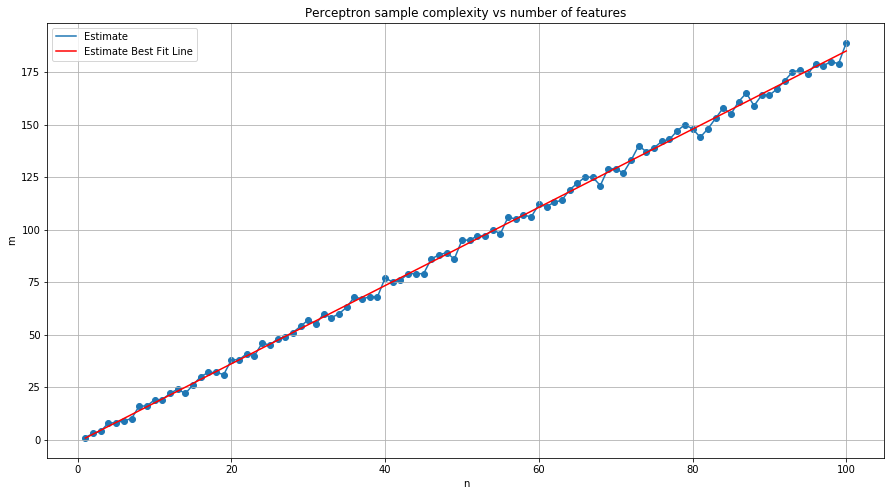

In [180]:
# Plot results for perceptron
plt.figure(figsize = (15,8))
plt.title('Perceptron sample complexity vs number of features')
plt.scatter(np.int32(1 + np.arange(len(min_ms_perceptron))), min_ms_perceptron)
plt.plot(np.int32(1 + np.arange(len(min_ms_perceptron))), min_ms_perceptron, label = 'Estimate')
plt.plot(np.int32(1 + np.arange(len(true_m))), true_m, label = 'Estimate Best Fit Line', color = 'r')
plt.grid()
plt.legend()
plt.xlabel("n")
plt.ylabel("m")

### Winnow Sample Complexity

In [48]:
# Compute almost exact
at_min_ms = []; model = Winnow(); n_trainsets = 200

# Iterate through n
start = time.time()
for n in 1 + np.arange(10):
    print(f"At n = {n}")
    # Iterate through m
    m = 1; satisfied = False; #n_testpts = int(150 * np.sqrt(n+2))
    start_m = time.time()
    while not satisfied:
        
        av_gen_err = compute_av_gen_err_almost_exact(model, n, m, n_trainsets, isOnline = True, is1NN = False, isWinnow = True)
        
        if av_gen_err <= 0.1:
            satisfied = True
            at_min_ms.append(m)
            print(f"For n = {n}, minimum m is {m}")
        else:
            m += 1
    print(f"For n = {n}, minimum m found in {time.time() - start_m}")
    
print(f"Everything done in {time.time() - start}")

At n = 1
For n = 1, minimum m is 1
For n = 1, minimum m found in 0.016920089721679688
At n = 2
For n = 2, minimum m is 3
For n = 2, minimum m found in 0.05916094779968262
At n = 3
For n = 3, minimum m is 9
For n = 3, minimum m found in 0.19043183326721191
At n = 4
For n = 4, minimum m is 10
For n = 4, minimum m found in 0.23976707458496094
At n = 5
For n = 5, minimum m is 13
For n = 5, minimum m found in 0.3265869617462158
At n = 6
For n = 6, minimum m is 16
For n = 6, minimum m found in 0.46575403213500977
At n = 7
For n = 7, minimum m is 15
For n = 7, minimum m found in 0.4229099750518799
At n = 8
For n = 8, minimum m is 16
For n = 8, minimum m found in 0.45756053924560547
At n = 9
For n = 9, minimum m is 16
For n = 9, minimum m found in 0.47921013832092285
At n = 10
For n = 10, minimum m is 16
For n = 10, minimum m found in 0.5011506080627441
Everything done in 3.159452199935913


In [181]:
win_min_ms = []; model = Winnow(); n_trainsets = 50

# Iterate through n
start = time.time()
for n in 1 + np.arange(100):
    print(f"At n = {n}")
    # Iterate through m
    m = 1; satisfied = False; n_testpts = int(150 * np.sqrt(n+2))
    start_m = time.time()
    while not satisfied:
        
        av_gen_err = compute_av_gen_err_approx(model, n, m, n_trainsets, n_testpts, isOnline = True, is1NN = False, isWinnow = True)
        
        if av_gen_err <= 0.1:
            satisfied = True
            win_min_ms.append(m)
            print(f"For n = {n}, minimum m is {m}")
        else:
            m += 1
    print(f"For n = {n}, minimum m found in {time.time() - start_m}")
    
print(f"Everything done in {time.time() - start}")

At n = 1
For n = 1, minimum m is 1
For n = 1, minimum m found in 0.005950450897216797
At n = 2
For n = 2, minimum m is 3
For n = 2, minimum m found in 0.017951250076293945
At n = 3
For n = 3, minimum m is 10
For n = 3, minimum m found in 0.07168793678283691
At n = 4
For n = 4, minimum m is 10
For n = 4, minimum m found in 0.07380461692810059
At n = 5
For n = 5, minimum m is 13
For n = 5, minimum m found in 0.10671520233154297
At n = 6
For n = 6, minimum m is 14
For n = 6, minimum m found in 0.1186821460723877
At n = 7
For n = 7, minimum m is 16
For n = 7, minimum m found in 0.14563751220703125
At n = 8
For n = 8, minimum m is 16
For n = 8, minimum m found in 0.15358948707580566
At n = 9
For n = 9, minimum m is 18
For n = 9, minimum m found in 0.1874992847442627
At n = 10
For n = 10, minimum m is 18
For n = 10, minimum m found in 0.1875302791595459
At n = 11
For n = 11, minimum m is 18
For n = 11, minimum m found in 0.19444823265075684
At n = 12
For n = 12, minimum m is 19
For n = 12, m

For n = 95, minimum m is 35
For n = 95, minimum m found in 2.8184664249420166
At n = 96
For n = 96, minimum m is 37
For n = 96, minimum m found in 3.008958339691162
At n = 97
For n = 97, minimum m is 34
For n = 97, minimum m found in 2.698941946029663
At n = 98
For n = 98, minimum m is 34
For n = 98, minimum m found in 2.803506851196289
At n = 99
For n = 99, minimum m is 33
For n = 99, minimum m found in 2.7017781734466553
At n = 100
For n = 100, minimum m is 35
For n = 100, minimum m found in 2.9551312923431396
Everything done in 110.30016493797302


In [222]:
x = np.log2(1 + np.arange(100))
line = sp.linregress(x, win_min_ms)
true_m = line.slope * np.log2(1 + np.arange(100)) + line.intercept
print(f"m = {line.slope} log_2 (n) + {line.intercept}")

m = 5.155860699573159 log_2 (n) + 0.563847945840088


Text(0, 0.5, 'm')

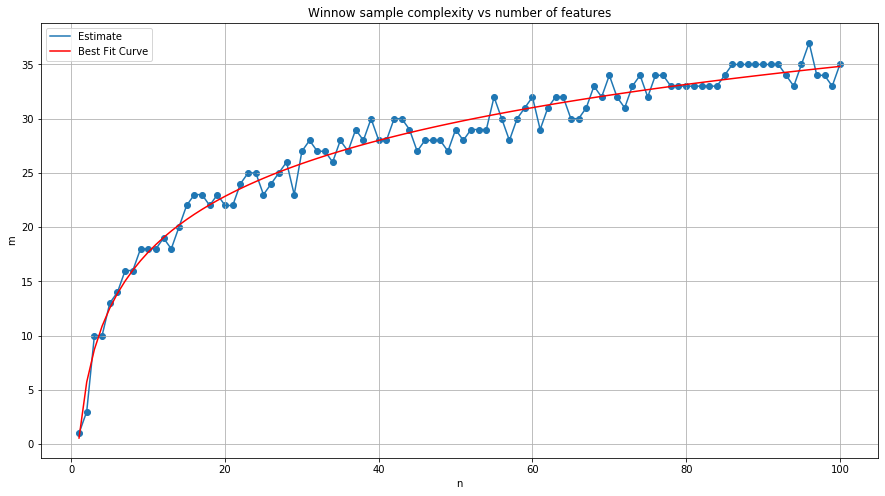

In [184]:
# Plot results
plt.figure(figsize = (15,8))
plt.title('Winnow sample complexity vs number of features')
plt.scatter(np.int32(1 + np.arange(len(win_min_ms))), win_min_ms)
plt.plot(np.int32(1 + np.arange(len(win_min_ms))), win_min_ms, label = 'Estimate')
plt.plot(np.int32(1 + np.arange(len(true_m))), true_m, label = 'Best Fit Curve', color = 'r')
plt.grid()
plt.legend()
plt.xlabel("n")
plt.ylabel("m")

### Linear Regression Sample Complexity

In [170]:
at_min_ms_lr = []; model = LinearRegression(); n_trainsets = 500

# Iterate through n
start = time.time()
for n in 1 + np.arange(10):
    print(f"At n = {n}")
    # Iterate through m
    m = 1; satisfied = False;
    start_m = time.time()
    while not satisfied:
        
        av_gen_err = compute_av_gen_err_almost_exact(model, n, m, n_trainsets, isOnline = False, is1NN = False, isWinnow = False)
        
        if av_gen_err <= 0.1:
            satisfied = True
            at_min_ms_lr.append(m)
            print(f"For n = {n}, minimum m is {m}")
        else:
            m += 1
    print(f"For n = {n}, minimum m found in {time.time() - start_m}")
    
print(f"Everything done in {time.time() - start}")

At n = 1
For n = 1, minimum m is 1
For n = 1, minimum m found in 0.05289006233215332
At n = 2
For n = 2, minimum m is 2
For n = 2, minimum m found in 0.10400843620300293
At n = 3
For n = 3, minimum m is 4
For n = 3, minimum m found in 0.21841645240783691
At n = 4
For n = 4, minimum m is 5
For n = 4, minimum m found in 0.2622990608215332
At n = 5
For n = 5, minimum m is 5
For n = 5, minimum m found in 0.2782559394836426
At n = 6
For n = 6, minimum m is 5
For n = 6, minimum m found in 0.2792534828186035
At n = 7
For n = 7, minimum m is 6
For n = 7, minimum m found in 0.3361015319824219
At n = 8
For n = 8, minimum m is 7
For n = 8, minimum m found in 0.4118995666503906
At n = 9
For n = 9, minimum m is 7
For n = 9, minimum m found in 0.43483734130859375
At n = 10
For n = 10, minimum m is 7
For n = 10, minimum m found in 0.4657886028289795
Everything done in 2.843750476837158


In [223]:
x = 1 + np.arange(len(min_ms_lr))
line = sp.linregress(x, min_ms_lr)
true_m = line.slope * (1 + np.arange(100)) + line.intercept
print(f"m = {line.slope}n + {line.intercept}")

m = 0.6148214821482146n + 1.1315151515151598


In [165]:
min_ms_lr = []; model = LinearRegression(); n_trainsets = 50

# Iterate through n
start = time.time()
for n in 1 + np.arange(100):
    print(f"At n = {n}")
    # Iterate through m
    m = 1; satisfied = False; #n_testpts = int(150 * np.sqrt(n+2))
#     n_testpts = 1500
    n_testpts = n*150
    start_m = time.time()
    while not satisfied:
        
        av_gen_err = compute_av_gen_err_approx(model, n, m, n_trainsets, n_testpts, isOnline = False, is1NN = False, isWinnow = False)
        
        if av_gen_err <= 0.1:
            satisfied = True
            min_ms_lr.append(m)
            print(f"For n = {n}, minimum m is {m}")
        else:
            m += 1
    print(f"For n = {n}, minimum m found in {time.time() - start_m}")
    
print(f"Everything done in {time.time() - start}")

At n = 1
For n = 1, minimum m is 1
For n = 1, minimum m found in 0.008976221084594727
At n = 2
For n = 2, minimum m is 2
For n = 2, minimum m found in 0.015957355499267578
At n = 3
For n = 3, minimum m is 4
For n = 3, minimum m found in 0.031946659088134766
At n = 4
For n = 4, minimum m is 5
For n = 4, minimum m found in 0.04201245307922363
At n = 5
For n = 5, minimum m is 6
For n = 5, minimum m found in 0.051696062088012695
At n = 6
For n = 6, minimum m is 5
For n = 6, minimum m found in 0.044368743896484375
At n = 7
For n = 7, minimum m is 6
For n = 7, minimum m found in 0.06186652183532715
At n = 8
For n = 8, minimum m is 6
For n = 8, minimum m found in 0.06379842758178711
At n = 9
For n = 9, minimum m is 6
For n = 9, minimum m found in 0.06983470916748047
At n = 10
For n = 10, minimum m is 7
For n = 10, minimum m found in 0.09575605392456055
At n = 11
For n = 11, minimum m is 8
For n = 11, minimum m found in 0.10875725746154785
At n = 12
For n = 12, minimum m is 8
For n = 12, minim

For n = 95, minimum m is 60
For n = 95, minimum m found in 43.13327097892761
At n = 96
For n = 96, minimum m is 60
For n = 96, minimum m found in 45.46845269203186
At n = 97
For n = 97, minimum m is 61
For n = 97, minimum m found in 47.409791469573975
At n = 98
For n = 98, minimum m is 62
For n = 98, minimum m found in 48.99811911582947
At n = 99
For n = 99, minimum m is 61
For n = 99, minimum m found in 48.48543310165405
At n = 100
For n = 100, minimum m is 62
For n = 100, minimum m found in 50.033270835876465
Everything done in 1314.0288197994232


Text(0, 0.5, 'm')

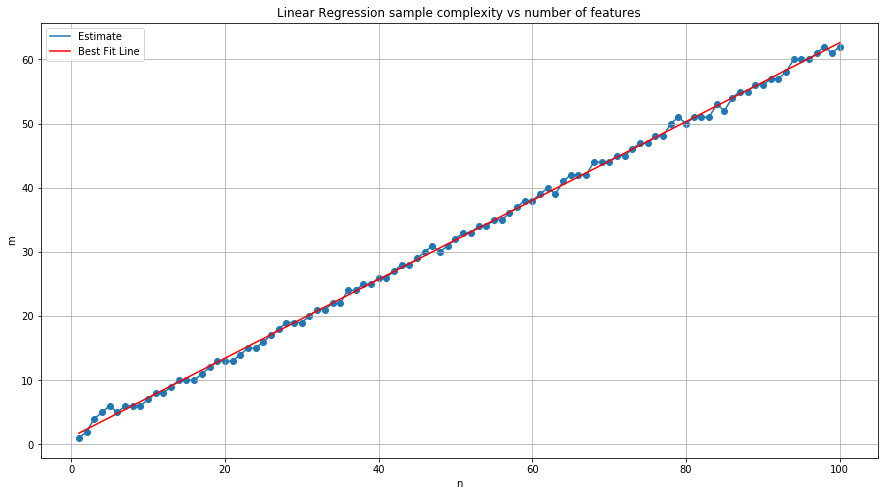

In [189]:
# Plot results
# Plot results for perceptron
plt.figure(figsize = (15,8))
plt.title('Linear Regression sample complexity vs number of features')
plt.scatter(np.int32(1 + np.arange(len(min_ms_lr))), min_ms_lr)
plt.plot(np.int32(1 + np.arange(len(min_ms_lr))), min_ms_lr, label = 'Estimate')
plt.plot(np.int32(1 + np.arange(len(true_m))), true_m, label = 'Best Fit Line', color = 'r')
plt.grid()
plt.legend()
plt.xlabel("n")
plt.ylabel("m")

### 1-NN

In [211]:
nn_min_ms = []; model = one_nn(); n_trainsets = 50

# Iterate through n
start = time.time()
for n in 1 + np.arange(20):
    print(f"At n = {n}")
    # Iterate through m. For one-nn, to speed process, we start at the m that is equal to the previous one for large m
    m = 1 if n <= 5 else round(1.2*prev_m)
    satisfied = False; n_testpts = 35*n
    start_m = time.time()
    while not satisfied:
        
        av_gen_err = compute_av_gen_err_approx(model, n, m, n_trainsets, n_testpts, isOnline = False, is1NN = True, isWinnow = False, seed = int(start))
        
        if av_gen_err <= 0.1:
            satisfied = True
            prev_m = m
            nn_min_ms.append(m)
            print(f"For n = {n}, minimum m is {m}")
        else:
            m += 1
    print(f"For n = {n}, minimum m found in {time.time() - start_m}")
    
print(f"Everything done in {time.time() - start}")

At n = 1
For n = 1, minimum m is 4
For n = 1, minimum m found in 0.023904800415039062
At n = 2
For n = 2, minimum m is 6
For n = 2, minimum m found in 0.031954288482666016
At n = 3
For n = 3, minimum m is 11
For n = 3, minimum m found in 0.06183314323425293
At n = 4
For n = 4, minimum m is 15
For n = 4, minimum m found in 0.08676457405090332
At n = 5
For n = 5, minimum m is 22
For n = 5, minimum m found in 0.13663077354431152
At n = 6
For n = 6, minimum m is 33
For n = 6, minimum m found in 0.07377195358276367
At n = 7
For n = 7, minimum m is 51
For n = 7, minimum m found in 0.1266624927520752
At n = 8
For n = 8, minimum m is 82
For n = 8, minimum m found in 0.31017041206359863
At n = 9
For n = 9, minimum m is 117
For n = 9, minimum m found in 0.41092967987060547
At n = 10
For n = 10, minimum m is 176
For n = 10, minimum m found in 1.1309490203857422
At n = 11
For n = 11, minimum m is 255
For n = 11, minimum m found in 2.20015549659729
At n = 12
For n = 12, minimum m is 334
For n = 12,

In [226]:
x = 1 + np.arange(len(nn_min_ms))
line = sp.linregress(x, np.log2(nn_min_ms))
true_m = 2**(line.slope * (1 + np.arange(len(nn_min_ms))) + line.intercept)
print(f"m = 2^({line.slope} n + {line.intercept})")

m = 2^(0.5802828427785282 n + 1.5852699696611863)


Text(0, 0.5, 'm')

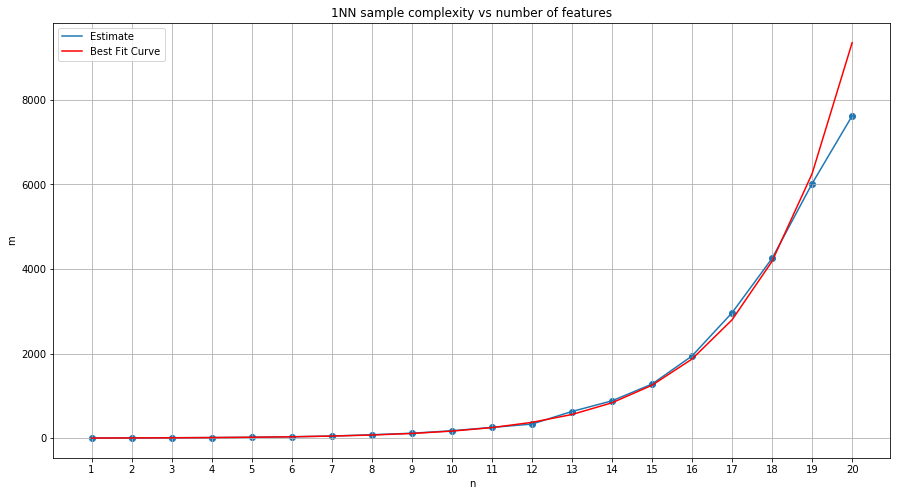

In [220]:
# Plot results
plt.figure(figsize = (15,8))
plt.title('1NN sample complexity vs number of features')
plt.scatter(np.int32(1 + np.arange(len(nn_min_ms))), nn_min_ms)
plt.plot(np.int32(1 + np.arange(len(nn_min_ms))), nn_min_ms, label = 'Estimate')
plt.plot((1+np.arange(len(nn_min_ms))), true_m, color = 'r', label = 'Best Fit Curve')
plt.grid()
plt.legend()
plt.xticks(1+np.arange(len(nn_min_ms), step = 1))
plt.xlabel("n")
plt.ylabel("m")